In [16]:
from __future__ import absolute_import, division, print_function

from hippylib import nb
import dolfin as dl
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
%matplotlib inline

import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
logging.getLogger('UFC').setLevel(logging.ERROR)
dl.set_log_active(False)

sys.path.insert(0,'/home/fenics/Installations/MUQ_INSTALL/lib')
from IPython.display import Image

# MUQ Includes
import pymuqModeling as mm # Needed for Gaussian distribution
import pymuqApproximation as ma # Needed for Gaussian processes
import pymuqSamplingAlgorithms as ms # Needed for MCMC

In [17]:
nx = ny = 10
mesh = dl.RectangleMesh(dl.Point(0, 0),dl.Point(1,1),nx,ny,"right")
V = dl.FunctionSpace(mesh, 'P', 1)
time_final = 0.05
numSteps = 100
c = 1.5

In [18]:
class PAT_forward(mm.PyModPiece):
    
    def __init__(self, time_final, numSteps, c, V):
        """ 
        INPUTS:
        
        
        """
        mm.PyModPiece.__init__(self, [V.dim()],[numSteps, V.dim()])
                  
        self.T_f = time_final
        self.numSteps = numSteps
        self.dt = self.T_f / self.numSteps
        self.c = c
        self.V = V
        
        self.p_trial = dl.TrialFunction(self.V)
        self.v = dl.TestFunction(self.V)
            
    def EvaluateImpl(self, inputs):
        """
        
        """
        m = dl.Function(self.V)
        m.vector().set_local(inputs[0])
        
        p_n = dl.interpolate(m, self.V)
        p_nm1 = dl.interpolate(m, self.V)
        p_trial = self.p_trial
        v = self.v
        
        F = (self.c**2)*(self.dt**2)*dl.inner(dl.grad(p_trial), dl.grad(v))*dl.dx - 2.*p_n*v*dl.dx + p_trial*v*dl.dx + p_nm1*v*dl.dx 
        a, L = dl.lhs(F), dl.rhs(F)
        
        # Time-stepping
        p = dl.Function(self.V)
        t = 0
        
        out = np.zeros((self.numSteps, self.V.dim()))
        for n in range(self.numSteps):
            # Update current timtime
            t += self.dt

            # Compute solution
            dl.solve(a == L, p)

            # Update previous solution
            p_nm1.assign(p_n)
            p_n.assign(p)
            out[n][:] = p.vector().get_local()
        
        self.outputs = [out]

In [19]:
fwdSolver = PAT_forward(time_final, numSteps, c, V)

# Prior
m = dl.interpolate(dl.Expression('exp(-(x[0]-0.5)*(x[0]-0.5) -(x[1]-0.5)*(x[1]-0.5))', degree=2), V)
logPriorMu = m.vector().get_local()
logPriorCov = 0.02*np.eye(V.dim())
logPrior = mm.Gaussian(logPriorMu, logPriorCov).AsDensity()
  
p0 = dl.interpolate(dl.Expression('exp(-(x[0]-0.5)*(x[0]-0.5) -(x[1]-0.5)*(x[1]-0.5))', degree=2), V)
obsData = fwdSolver.Evaluate([p0.vector().get_local()])[0]   

TypeError: (): incompatible function arguments. The following argument types are supported:
    1. (self: pymuqModeling.PyModPiece, arg0: List[numpy.ndarray[float64[m, 1]]]) -> None

Invoked with: <__main__.PAT_forward object at 0x7f996087cbf8>, [array([[ 0.60656345,  0.663656  ,  0.663656  , ...,  0.663656  ,
         0.663656  ,  0.60656345],
       [ 0.60662899,  0.6636675 ,  0.6636675 , ...,  0.6636675 ,
         0.6636675 ,  0.60662899],
       [ 0.60672721,  0.66368476,  0.66368476, ...,  0.66368476,
         0.66368476,  0.60672721],
       ..., 
       [ 0.70371936,  0.69827044,  0.69827044, ...,  0.69827044,
         0.69827044,  0.70371936],
       [ 0.70485504,  0.69900964,  0.69900964, ...,  0.69900964,
         0.69900964,  0.70485504],
       [ 0.7059806 ,  0.69975476,  0.69975476, ...,  0.69975476,
         0.69975476,  0.7059806 ]])]

# Likelihood

In [3]:
noiseVar = 1e-4
noiseCov = noiseVar*np.eye(obsData.shape[0])
likelihood = mm.Gaussian(obsData, noiseCov).AsDensity()

# Posterior

In [4]:
posteriorPiece = mm.DensityProduct(2)
p_0 = mm.IdentityOperator(V.dim())

In [5]:
graph = mm.WorkGraph()

# Forward model nodes and edges
graph.AddNode(p_0, "p_0")
#graph.AddNode(obsOperator, "B")
graph.AddNode(fwdSolver, "u")

graph.AddEdge("p_0", 0, "u", 0)
#graph.AddEdge("u", 0, "B", 0)

# Other nodes and edges
graph.AddNode(likelihood, "Likelihood")
graph.AddNode(logPrior, "Prior")
graph.AddNode(posteriorPiece,"Posterior")

#graph.AddEdge("B", 0, "Likelihood", 0)
graph.AddEdge("u", 0, "Likelihood", 0)
graph.AddEdge("p_0", 0, "Prior", 0)
graph.AddEdge("Prior",0,"Posterior",0)
graph.AddEdge("Likelihood",0, "Posterior",1)

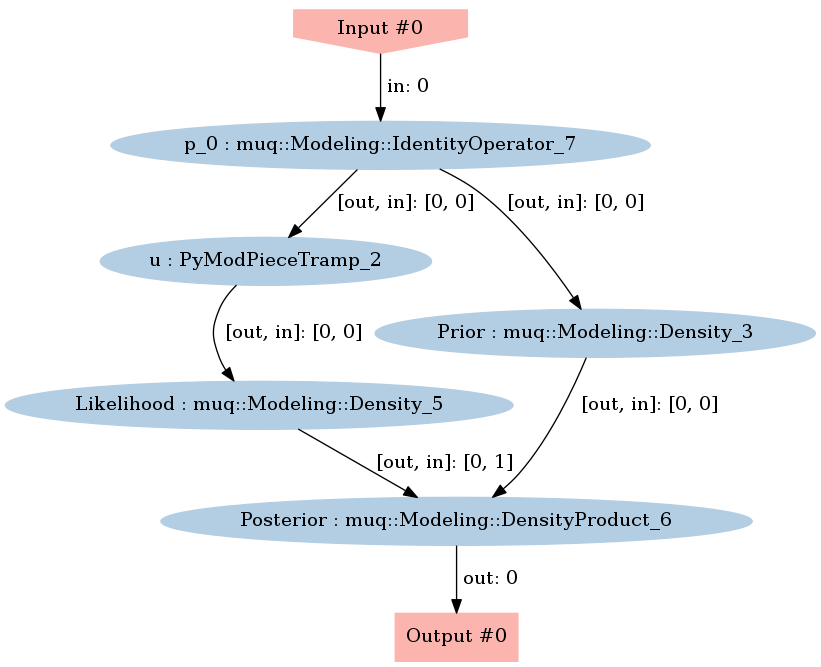

In [6]:
graph.Visualize("PosteriorGraph.png")
Image(filename='PosteriorGraph.png') 

In [7]:
problem = ms.SamplingProblem(graph.CreateModPiece("Posterior"))

In [14]:
proposalOptions = dict()
proposalOptions['Method'] = 'AMProposal'
proposalOptions['ProposalVariance'] = 1e-1
proposalOptions['AdaptSteps'] = 100
proposalOptions['AdaptStart'] = 1000
proposalOptions['AdaptScale'] = 0.1

kernelOptions = dict()
kernelOptions['Method'] = 'MHKernel'
kernelOptions['Proposal'] = 'ProposalBlock'
kernelOptions['ProposalBlock'] = proposalOptions

options = dict()
options['NumSamples'] = 2000
options['ThinIncrement'] = 1
options['BurnIn'] = 1
options['KernelList'] = 'Kernel1'
options['PrintLevel'] = 3
options['Kernel1'] = kernelOptions

mcmc = ms.SingleChainMCMC(options,problem)

In [15]:
startPt = np.log(8.0) * np.ones((V.dim()))
samps = mcmc.Run(startPt)

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      Acceptance Rate = 16%
  20% Complete
    Block 0:
      Acceptance Rate = 11%
  30% Complete
    Block 0:
      Acceptance Rate = 8.5%
  40% Complete
    Block 0:
      Acceptance Rate = 6.6%
  50% Complete
    Block 0:
      Acceptance Rate = 5.5%
  60% Complete
    Block 0:
      Acceptance Rate = 4.8%
  70% Complete
    Block 0:
      Acceptance Rate = 4.1%
  80% Complete
    Block 0:
      Acceptance Rate = 3.6%
  90% Complete
    Block 0:
      Acceptance Rate = 3.2%
  100% Complete
    Block 0:
      Acceptance Rate = 2.9%
Completed in 701.774 seconds.


Effective Sample Size = 
 [  5.56224929   4.77371718   4.51063687   5.21040861   8.3319255
  10.55979875   4.55673604   4.52471693   5.60482184   9.41799581
   5.34505766   7.9125227    4.54777778   8.82658942   4.66767055
   5.35093622   4.5725075    4.90485855   4.54867821   4.65178314
   8.41890945   4.74909848   5.36510656  16.52384095   4.48604872
   6.87802063   4.62504113   4.64545754   5.15639916   4.78418217
   4.98301243   4.51952581   4.59456092   4.55753966   6.54638987
   4.59518853   8.51446772  11.42757082   4.56849501   6.44972292
   5.31105058   4.64353292   4.92238896   4.58935454   4.55674429
   4.89808804   5.88735871   6.66917411   4.49893839   4.36598106
   5.36108485   5.21225897   8.71967875  10.22838865   7.47106354
   7.08934637   4.52290893   8.74659959   4.58007516   4.68449501
   4.30608538   4.61670839   8.35708279   4.57469627   5.83104583
   5.55594995   4.61003526   7.52428933   5.11188042   4.50801805
   7.10647098   4.58012806   5.34962896   5.0999725

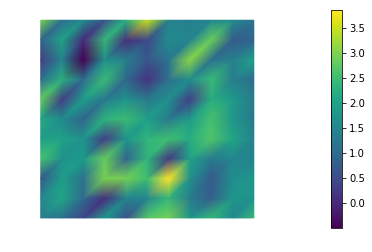

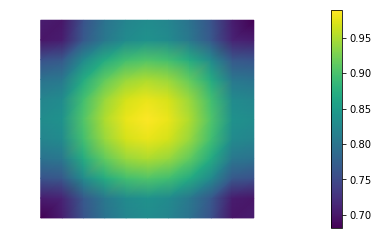

In [10]:
ess = samps.ESS()
print('Effective Sample Size = \n', ess)

sampMean = samps.Mean()
print('\nSample mean = \n', sampMean)

sampCov = samps.Covariance()
print('\nSample Covariance = \n', sampCov)

mcErr = np.sqrt( samps.Variance() / ess)
print('\nEstimated MC error in mean = \n', mcErr)

m = dl.Function(V)
m.vector().set_local(sampMean)
nb.plot(m)
plt.show()
 
obsFunc = dl.Function(V)
obsFunc.vector().set_local(obsData)
nb.plot(obsFunc)
plt.show()

In [11]:
sampMat = samps.AsMatrix()

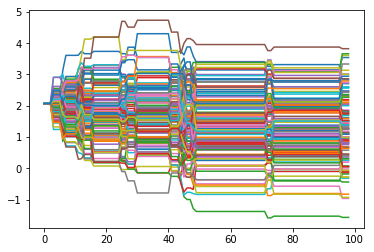

In [12]:
plt.plot(sampMat.T)
plt.show()

# Plot samples of the posterior predictive

In [13]:
#predSamps = np.zeros((numPts, sampMat.shape[1]))

#predModel = graph.CreateModPiece("u")

#for i in range(sampMat.shape[1]):
#    predSamps[:,i] = predModel.Evaluate([ sampMat[:,i] ])[0]

NameError: name 'numPts' is not defined